In [1]:
import sympy as sy

import IPython
from IPython.display import display

import matplotlib.pyplot as plt

import numpy as np

from scipy.integrate import odeint

def displayH(a1,a2='', a3='', a4='', a5='', a6='', a7='',):
    latex_a1 = sy.latex(a1)
    latex_a2 = sy.latex(a2)
    latex_a3 = sy.latex(a3)
    latex_a4 = sy.latex(a4)
    latex_a5 = sy.latex(a5)
    latex_a6 = sy.latex(a6)
    latex_a7 = sy.latex(a7)
    display( IPython.core.display.Math(latex_a1 + latex_a2 + latex_a3 + latex_a4 + latex_a5 + latex_a6 + latex_a7)  )

$\newpage$

## 1. Quaternion-based Attitude Control Using Reaction Wheels

A spacecraft needs to perform a reorientation maneuver using reaction wheels.

The spacecraft moment of inertia matrix is,
$$
I = \begin{bmatrix} 6400 & -76.4 & -25.6 \\ -76.4 & 4730 & -4.0 \\ -25.6 & -4.0 & 8160 \end{bmatrix} \text{ kg-m}^2.
$$

The spacecraft orientation at the initial time $t_0 = 0$, is given by the quaternion,
$$
q(t_0) = \frac{1}{2} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix}
$$
and the spacecraft initial angular velocity is given by
$$
\omega(t_0) = \begin{bmatrix} 0.01 \\ 0.01 \\ 0.01 \end{bmatrix} \text{ rad/s}.
$$
At $t_0$ the reaction wheels are not spinning, therefore, the initial wheel momentum is $h_w(t_0) = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix} \text{ kg-m}^2/\text{s}$.
The commanded (desired) quaternion is the identity quaternion,
$$
q_c = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}.
$$
Unlike the quaternion vector we have discussed in class, $\beta = \begin{bmatrix} \beta_0 & \beta_1 & \beta_2 & \beta_3 \end{bmatrix}^T$, the quaternion for this problem, $q = \begin{bmatrix} q_1 & q_2 & q_3 & q_4 \end{bmatrix}^T$ has the scalar component as the fourth entry. As a result, we’ll be using slightly modified equations.

In addition to achieving the commanded quaternion, it is desired that the spacecraft come to a complete stop, i.e., the final angular velocity at the commanded quaternion should be $\omega_2 = \left[\begin{array}{c} 0 \\ 0 \\ 0 \end{array}\right] \text{ rad/s}$.
For this purpose the following quaternion-based proportional-derivative control law needs to be tested:
$$
L_s = -k_p \text{sign}(\delta q_4) \delta q_{1:3} - k_d \omega
$$
where,
 - $L_s$ = control torque on the spacecraft
 - $k_p = 10$ is the proportional control gain
 - $k_d = 150$ is the derivative control gain
 - $\delta q_{1:3} = \left[\begin{array}{c} \delta q_1 & \delta q_2 & \delta q_3 \end{array}\right]^T$ is the quaternion error

Error $\delta q$ between any quaternion$q$and the commanded quaternion $q_c$ can be found as follows,
$$
\delta q_{1:3} = \left[ A(\bar{q}) \right]^T q
$$
where
$$
\delta q_4 = \bar{q} \cdot q
$$
and
$$
A(\bar{q}) = \left[\begin{array}{ccc} \bar{q}_4 & -\bar{q}_3 & \bar{q}_2 \\ \bar{q}_3 & \bar{q}_4 & -\bar{q}_1 \\ -\bar{q}_2 & \bar{q}_1 & \bar{q}_4 \\ -\bar{q}_1 & -\bar{q}_2 & -\bar{q}_3 \end{array}\right]
$$
for a generic quaternion $\bar{q} = \left[\begin{array}{c} \bar{q}_1 & \bar{q}_2 & \bar{q}_3 & \bar{q}_4 \end{array}\right]^T$.

Perform the following tasks:

### (a) Simulated Attitude Dynamics
Simulate the controlled attitude dynamics of the spacecraft. The coupled differential equations for quaternion and the angular velocity vectors are,
$$
\dot{\mathbf{q}} = \frac{1}{2}A(\mathbf{q})\mathbf{\omega}
$$
$$
I\dot{\mathbf{\omega}}+\mathbf{\omega}\times I\mathbf{\omega}=L_s
$$
Plot the time histories $q(t)$ and $\omega(t)$ over the time interval t = (0, 1 sec, 2 sec, . . . , 20 min).
Does the proposed control law successfully reorient the spacecraft and bring it to rest?

In [2]:
I = np.array([[6400,-76.4,-25.6],
              [-76.4, 4730, -4.0],
              [-25.6,-4.0,8160]])

t0 = 0
tf = 20*60
times = np.arange(t0,tf+0.01,1)

q0 = 1/(2)**0.5*np.array([1,0,0,1])
w0 = np.array([0.01,0.01,0.01])
hw0 = np.array([0,0,0])
x0 = np.hstack([q0,w0,hw0])

qc = np.array([0,0,0,1])

kp=50
kd=150

In [3]:
def A(q):
    return np.array([[ q[3], -q[2],  q[1]],
                     [ q[2],  q[3], -q[0]],
                     [-q[1],  q[0],  q[3]],
                     [-q[0], -q[1], -q[2]]])

def Ls(q,w):
    dq = np.zeros(4)
    dq[:3] = A(qc).T@q
    dq[3] = qc.T@q0
    return -kp*np.sign(dq[3])*dq[:3]-kd*w

def EOM(x,t):
    q = x[:4]
    w = x[4:7]
    hw = x[7:]
    dq = 0.5*A(q)@w
    dwI = Ls(q,w)-np.cross(w,I@w)
    Lw = -Ls(q,w)
    dhw = Lw-np.cross(w,hw)
    return [dq[0],
            dq[1],
            dq[2],
            dq[3],
            dwI[0]/I[0,0],
            dwI[1]/I[1,1],
            dwI[2]/I[2,2],
            dhw[0],
            dhw[1],
            dhw[2]]

x = odeint(EOM,x0,times).T
q = x[:4]
w = x[4:7]
hw = x[7:]

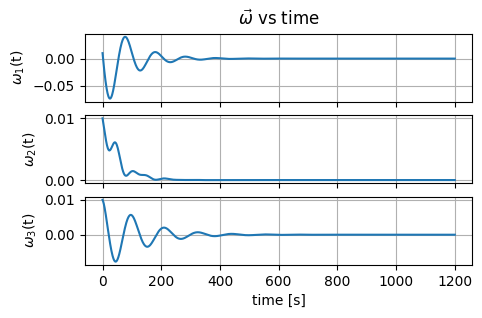

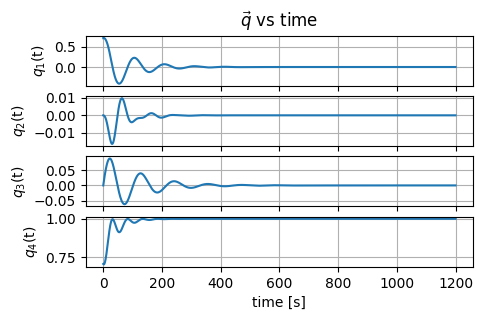

In [4]:
fig,axes = plt.subplots(3,sharex=True,figsize=(5,3))
axes[0].set_title(r"$\vec{\omega}\text{ vs time}$")
for idx,var_name in enumerate([r"$\omega_1$",
                                r"$\omega_2$",
                                r"$\omega_3$"]):
    axes[idx].plot(times,w[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

fig,axes = plt.subplots(4,sharex=True,figsize=(5,3))
axes[0].set_title(r"$\vec{q}\text{ vs time}$")
for idx,var_name in enumerate([r"$q_1$",
                                r"$q_2$",
                                r"$q_3$",
                                r"$q_4$"]):
    axes[idx].plot(times,q[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

Yes, the proposed control law does successfully reorient the spacecraft and bring it to rest.

### (b) Reaction Wheels
While the control torque on the spacecraft is $\mathbf{L_s}$, the reaction wheels experience an equal and opposite torque,$\mathbf{L_w} = −\mathbf{L_s}$.
Therefore, the governing differential equation for the wheel angular momentum
is,
$$
\dot{\mathbf{h}}_{\omega} + \mathbf{\omega}\times \mathbf{h}_w = \mathbf{L}_w
$$
Assuming the initial wheel momentum to be $\mathbf{h}_{\omega}(t_0) = \left[\begin{array}{ccc}0&0&0^T\end{array}\right]$ kg m2 /s, plot
the time history $\textbf{h}_{\omega}(t)$.

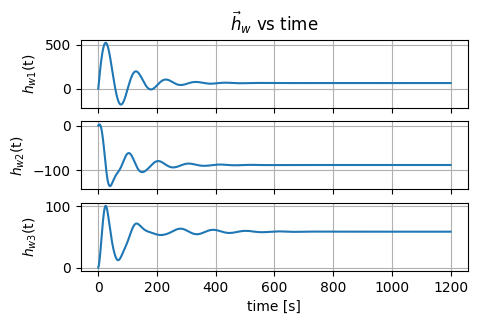

In [5]:
fig,axes = plt.subplots(3,sharex=True,figsize=(5,3))
axes[0].set_title(r"$\vec{h}_w\text{ vs time}$")
for idx,var_name in enumerate([r"$h_{w1}$",
                                r"$h_{w2}$",
                                r"$h_{w3}$"]):
    axes[idx].plot(times,hw[idx])
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[-1].set_xlabel("time [s]")
plt.show()

$\newpage$

## 2. Redundant Reaction Wheel Configurations

The $h_{\omega}(t)$ found in the previous problem is the wheel angular momentum requirement in the body frame to perform the reorientation maneuver. This angular momentum is provided by the following two redundant configurations of four reaction wheels:

1. Pyramid configuration:
  $$
  \hat{\mathbf{\omega}}_1 = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \\ 0 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_2 = \frac{1}{\sqrt{2}} \begin{bmatrix} -1 \\ 1 \\ 0 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_3 = \frac{1}{\sqrt{2}} \begin{bmatrix} 0 \\ 1 \\ 1 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_4 = \frac{1}{\sqrt{2}} \begin{bmatrix} 0 \\ -1 \\ 1 \end{bmatrix}
  $$

2. NASA standard configuration:
  $$
  \hat{\mathbf{\omega}}_1 = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_2 = \begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_3 = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
  $$
  $$
  \hat{\mathbf{\omega}}_4 = \frac{1}{\sqrt{3}} \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix}
  $$

where $\hat{\mathbf{\omega}}_i$ for $i = 1, 2, 3, 4$ represent the unit vectors along the spin axes of the reaction wheels in the body frame for each respective configuration.

Perform the following tasks:

### (a) Pseudoinverse Law
Using the pseudoinverse distribution law, calculate and plot the time histories of the angular momentum for the redundant set of wheels, i.e., plot $h_1^{\omega}(t)$ , $h_2^{\omega}(t)$ , $h_3^{\omega}(t)$ , and $h_4^{\omega}(t)$ for both reaction wheel configurations.


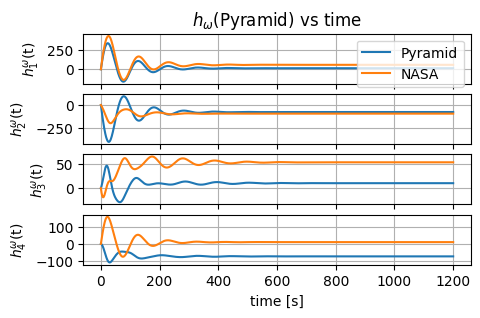

In [6]:
# Pyramid Configuration

w1_Pyramid = 1/(2)**0.5*np.array([1,1,0])
w2_Pyramid = 1/(2)**0.5*np.array([-1,1,0])
w3_Pyramid = 1/(2)**0.5*np.array([0,1,1])
w4_Pyramid = 1/(2)**0.5*np.array([0,1,-1])

psuedo_inv_Pyramid = np.linalg.pinv(np.array([w1_Pyramid,w2_Pyramid,w3_Pyramid,w4_Pyramid]).T)

hw_decomposed_Pyramid = np.array([psuedo_inv_Pyramid@h for h in hw.T]).T

# NASA Configuration

w1_NASA = np.array([1,0,0])
w2_NASA = np.array([0,1,0])
w3_NASA = np.array([0,0,1])
w4_NASA = 1/(3)**0.5*np.array([1,1,1])

psuedo_inv_NASA = np.linalg.pinv(np.array([w1_NASA,w2_NASA,w3_NASA,w4_NASA]).T)

hw_decomposed_NASA = np.array([psuedo_inv_NASA@h for h in hw.T]).T

fig,axes = plt.subplots(4,sharex=True,figsize=(5,3))
axes[0].set_title(r"$h_{\omega}\text{(Pyramid) vs time}$")
for idx,var_name in enumerate([r"$h_1^{\omega}$",
                                r"$h_2^{\omega}$",
                                r"$h_3^{\omega}$",
                                r"$h_4^{\omega}$"]):
    axes[idx].plot(times,hw_decomposed_Pyramid[idx],label="Pyramid")
    axes[idx].plot(times,hw_decomposed_NASA[idx],label="NASA")
    axes[idx].set_ylabel(var_name+"(t)")
    axes[idx].grid()
axes[0].legend(loc="upper right")
axes[-1].set_xlabel("time [s]")
plt.show()

### (b) Norms/Steady State
Additionally, plot the norm of the wheel momentum over time for both the pyramid configuration and the NASA standard configuration. What are the steady-state numerical values of the wheel momentum norms for each configuration?

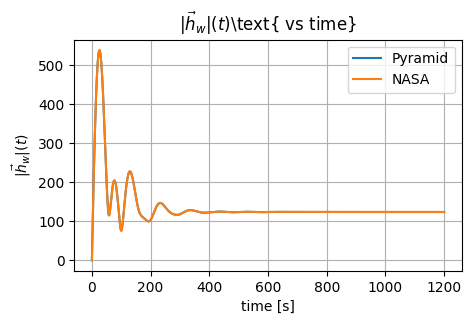

Steady State (Pyramid): 123.78153341853746
Steady State (NASA): 123.78153341853749


In [7]:
total_hw_NASA = np.array([h@np.array([w1_NASA,w2_NASA,w3_NASA,w4_NASA]) for h in hw_decomposed_NASA.T])
total_hw_Pyramid = np.array([h@np.array([w1_Pyramid,w2_Pyramid,w3_Pyramid,w4_Pyramid]) for h in hw_decomposed_Pyramid.T])

fig,ax = plt.subplots(1,figsize=(5,3))
ax.set_title(r"$|\vec{h}_w|(t)$\text{ vs time}")
ax.set_ylabel(r"$|\vec{h}_w|(t)$")
ax.plot(times,np.linalg.norm(total_hw_Pyramid,axis=1),label="Pyramid")
ax.plot(times,np.linalg.norm(total_hw_NASA,axis=1),label="NASA")
ax.grid()
ax.legend(loc="upper right")
ax.set_xlabel("time [s]")
plt.show()

print("Steady State (Pyramid):",np.linalg.norm(total_hw_Pyramid,axis=1)[-1])
print("Steady State (NASA):",np.linalg.norm(total_hw_NASA,axis=1)[-1])